In [1]:

import json
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F

connection_parameters = json.load(open('../connection.json'))
session = Session.builder.configs(connection_parameters).create()



### 1. Build docker image and push the image to image registry

- Run the below code from terminal or execute the next cell by updating the connection details

<!-- Run below commands from a terminal. Update the ORGNAME-ACCTNAME with your account info and alsp update the IMAGE_REPOSITORY, DATABASE and SCHEMA NAME -->

```
cd streamlit

docker build --no-cache --platform linux/amd64 -t ORGNAME-ACCTNAME.registry.snowflakecomputing.com/DATABASE/SCHEMA/IMAGE_REPOSITORY/streamlitapp:latest . 

docker login ORGNAME-ACCTNAME.registry.snowflakecomputing.com -u <username>


docker push ORGNAME-ACCTNAME.registry.snowflakecomputing.com/DATABASE/SCHEMA/IMAGE_REPOSITORY/streamlitapp:latest
```

In [29]:
%%bash
# Run below commands by updating the ORGNAME-ACCTNAME with your account info .
# Also update the IMAGE_REPOSITORY, DATABASE and SCHEMA NAME and username

# You can execute the same commands from terminal as well
cd cd streamlit

docker build --no-cache --platform linux/amd64 -t ORGNAME-ACCTNAME.registry.snowflakecomputing.com/DATABASE/SCHEMA/IMAGE_REPOSITORY/streamlitapp:latest . 

docker login ORGNAME-ACCTNAME.registry.snowflakecomputing.com -u <username>

docker push ORGNAME-ACCTNAME.registry.snowflakecomputing.com/DATABASE/SCHEMA/IMAGE_REPOSITORY/streamlitapp:latest


### 2. Create the Compute Pool and BIND SERVICE ENDPOINT

Run the below command in Snowsight as <b>AccountAdmin</b> . Replace role SPCS_PSE_ROLE with your own role name if you have created with different name.

``` sql
USE ROLE ACCOUNTADMIN;

CREATE COMPUTE POOL PR_AudioAnalytics_Pool
  MIN_NODES = 1
  MAX_NODES = 1
  INSTANCE_FAMILY = CPU_X64_XS
  AUTO_RESUME = TRUE
  AUTO_SUSPEND_SECS = 3600
  INITIALLY_SUSPENDED = FALSE
    COMMENT = 'For Running Audio Analytics Streamlit App' ;

GRANT USAGE, MONITOR ON COMPUTE POOL PR_AudioAnalytics_Pool TO ROLE SPCS_PSE_ROLE;

-- Execute the below command if you have not used audio2text container
GRANT BIND SERVICE ENDPOINT ON ACCOUNT TO ROLE SPCS_PSE_ROLE ;

-- Below network rule and External Access INtegration is used to download the whisper mode.

-- You need to execute the below two commands only once for all the SPC services that you will be creating. If you have already created the below rule and EAI, ignore execute the below two commands.

 CREATE NETWORK RULE allow_all_rule
    TYPE = 'HOST_PORT'
    MODE= 'EGRESS'
    VALUE_LIST = ('0.0.0.0:443','0.0.0.0:80');

CREATE EXTERNAL ACCESS INTEGRATION allow_all_eai
  ALLOWED_NETWORK_RULES = (allow_all_rule)
  ENABLED = true

GRANT USAGE ON INTEGRATION allow_all_eai TO ROLE SPCS_PSE_ROLE;

```

#### 3. Create SPC Servie

Update th YAML to change the image value before executing the below file.put command

image: ORGNAME-ACCTNAME.registry.snowflakecomputing.com/dbname/schemaname/imagerepo_name/streamlitapp:latest


Update the YAML file with the name of the warehouse you have created before uploading to stage. 

This will be the warehouse which is used for the snowpark session used in the streamlit app.

![image](Streamlit_Warehouse.png)


In [4]:

session.file.put("./audioanalytics_streamlit_app.yaml", "@specs", auto_compress=False)

[PutResult(source='llm-text2sql.yaml', target='llm-text2sql.yaml.gz', source_size=652, target_size=358, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [ ]:
# Create the service
session.sql('''
create service audio_analytics_app
in compute pool PR_AudioAnalytics_Pool
from @specs
spec='audioanalytics_streamlit_app.yaml'
EXTERNAL_ACCESS_INTEGRATIONS = (ALLOW_ALL_EAI)

            ''').collect()

> Note the status of the service should in Ready before accessing the endpoint which is the streamlit app

In [2]:
#  Check the status of service
import ast
res=session.sql(''' 
SELECT SYSTEM$GET_SERVICE_STATUS('audio_analytics_app',1)
''').collect()[0][0]
ast.literal_eval(res)[0]

{'status': 'SUSPENDED',
 'message': 'Suspended',
 'containerName': 'audioanalytics-app',
 'instanceId': '0',
 'serviceName': 'AUDIO_ANALYTICS_APP',
 'image': 'sfseeurope-us-west-ccarrero-452.registry.snowflakecomputing.com/pr_llmdemo/public/images/streamlitapp:latest',
 'restartCount': 0,
 'startTime': ''}

In [4]:
# Check the service logs for any errors
session.sql('''SELECT value AS log_line
FROM TABLE(
 SPLIT_TO_TABLE(SYSTEM$GET_SERVICE_LOGS('audio_analytics_app', 0, 'audioanalytics-app'), '\n')
  )''').to_pandas()

### 4. Accessing Streamlit APP 

Wait for the status of the service to be running before moving to next step 

Run the below query to get the api endpoint for the Streamlit App. Get the <b>ingress_url </b>(this endpoint will launch the app)  from the below query output.

Ouput that you would get after running the below query.

Row(name='streamlit-app', port=8501, protocol='TCP', ingress_enabled='true', ingress_url='test999-us-west-ccarrero-452.snowflakecomputing.app')

In [5]:
session.sql('''show endpoints in service audio_analytics_app;
            ''').collect()[0]

#Row(name='streamlit-app', port=8501, protocol='TCP', ingress_enabled='true', ingress_url='gmtqocoj-sfseeurope-us-west-ccarrero-452.snowflakecomputing.app')

Row(name='streamlit-app', port=8501, protocol='TCP', ingress_enabled='true', ingress_url='gmtqocoj-sfseeurope-us-west-ccarrero-452.snowflakecomputing.app')

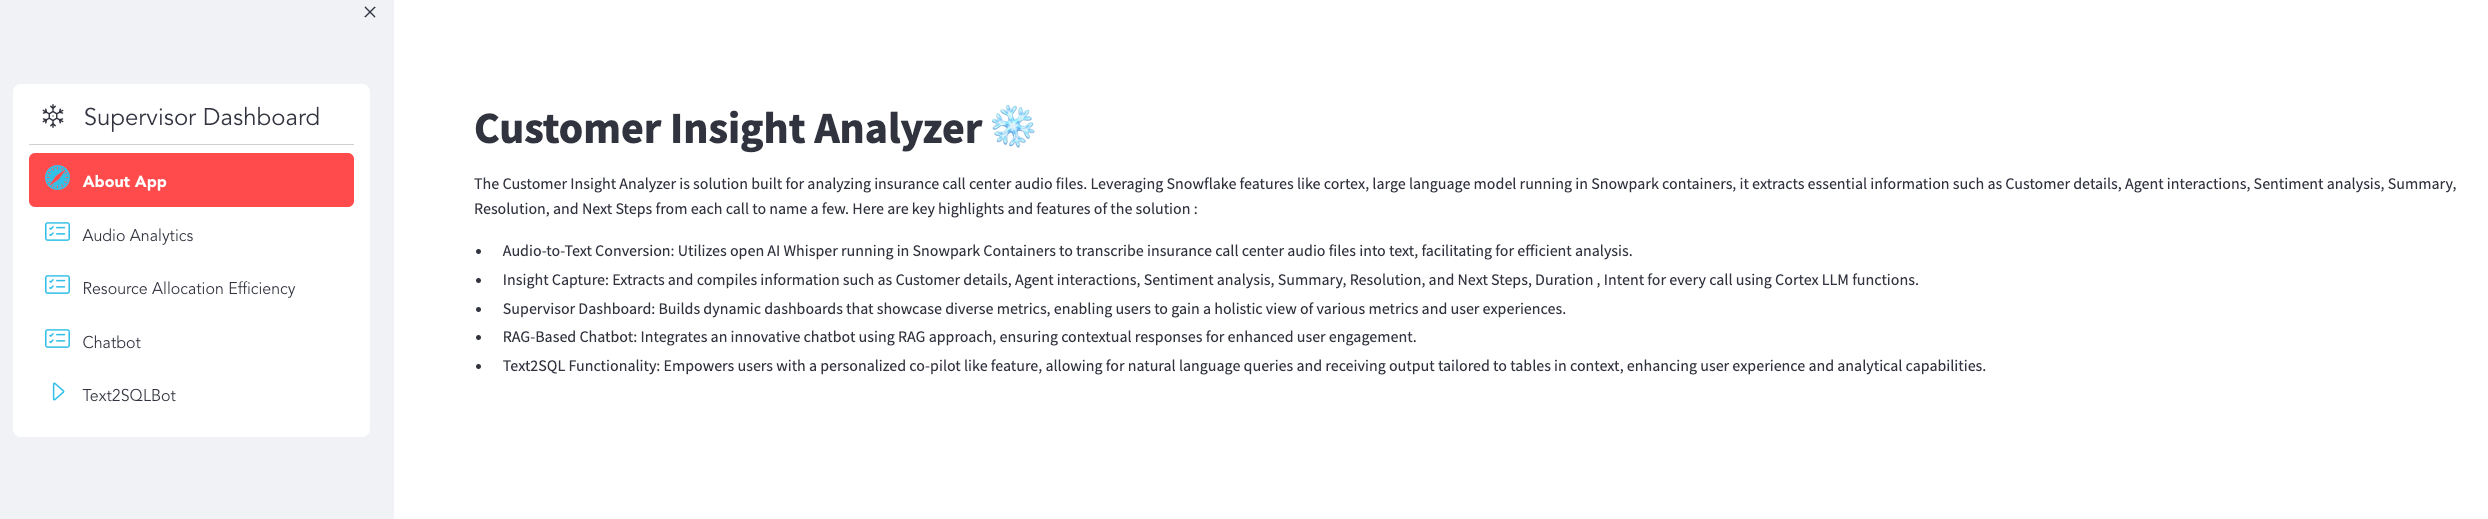

> Note if you are getting errors like 'SnowparkSQLException:(1304) No active warehouse in the current session' while access Audio Analytics or other section. 

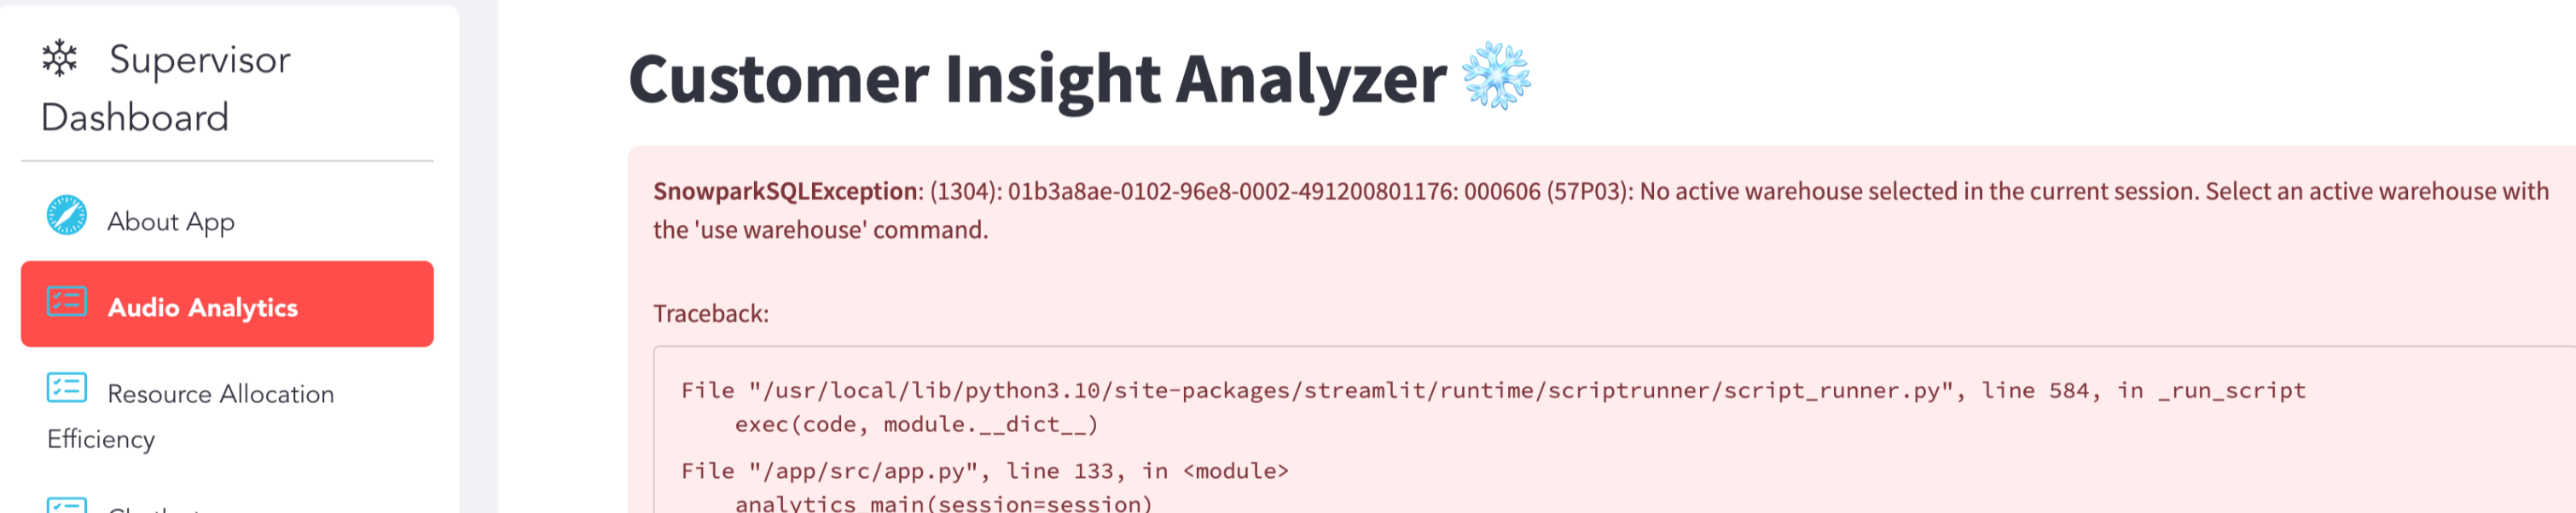

In this case you should hardcode the warehouse name as mentioned below in the app.py file.


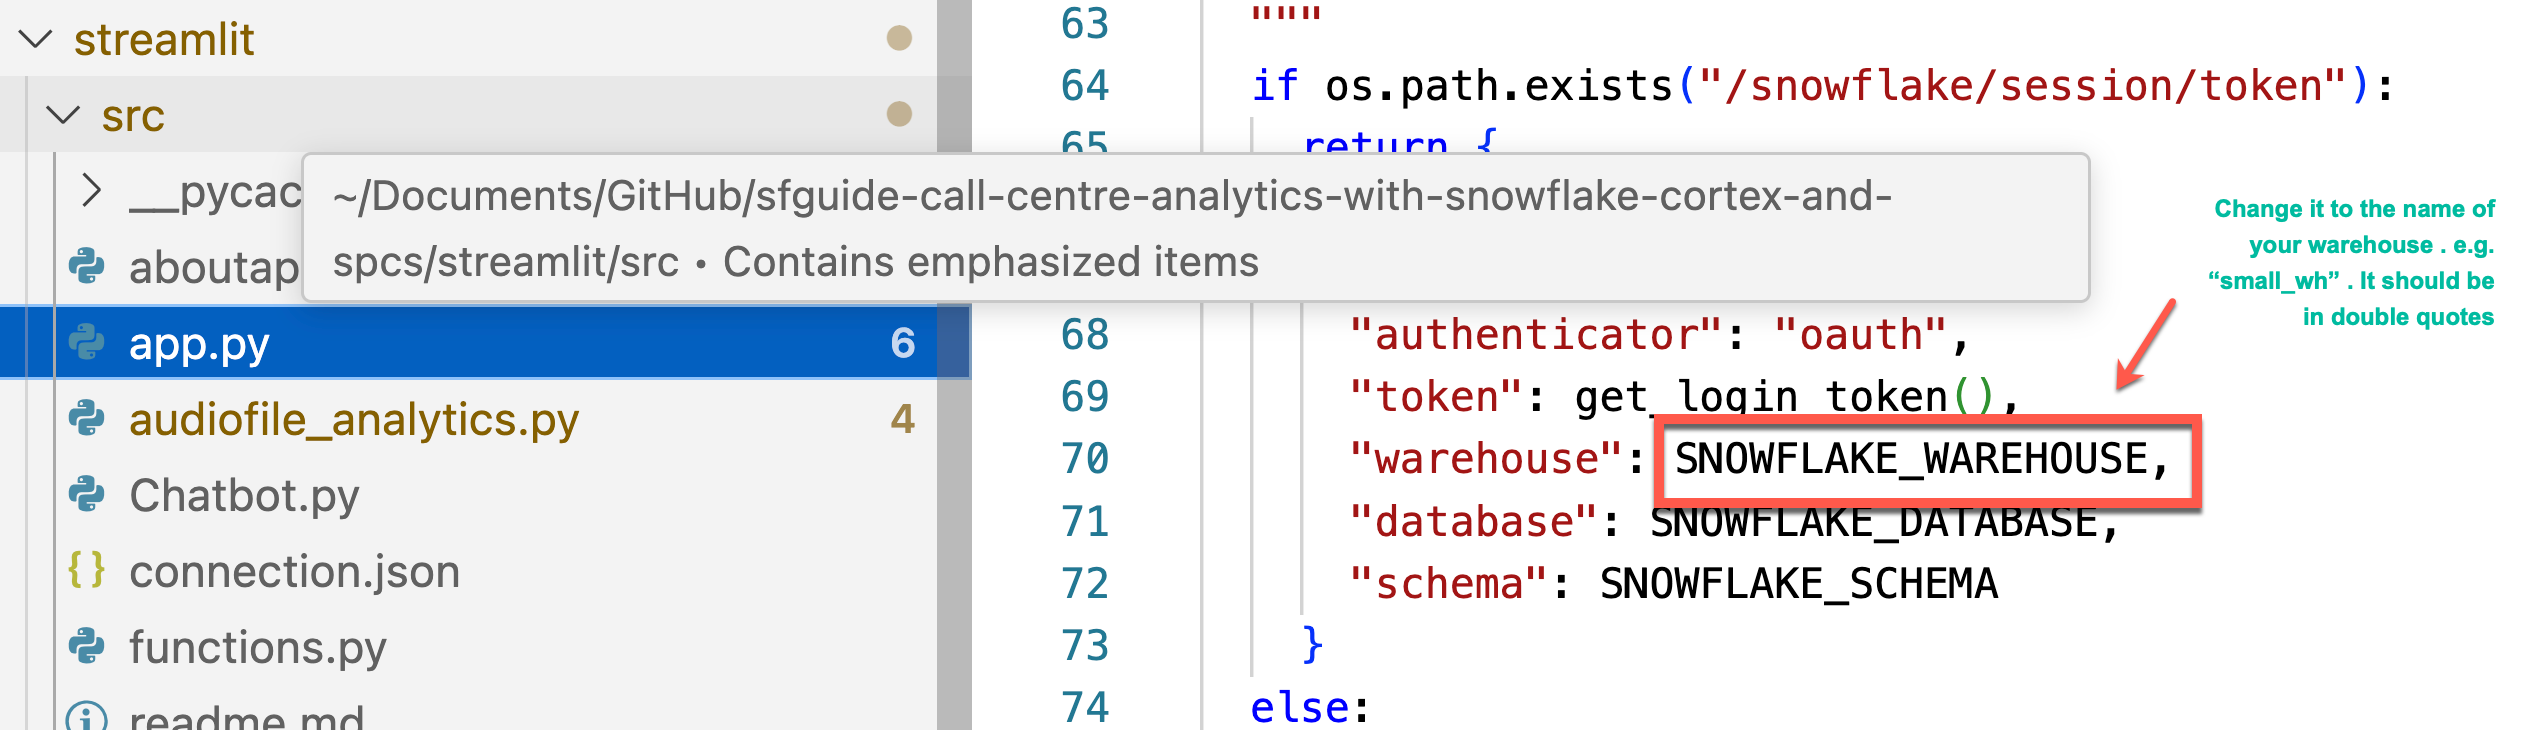

After making the changes mentioned above, rebuild the image, upload to the registry and the recreate the service.